# Training and Sampling a Restricted Boltzmann Machine with QuCumber

Welcome to the tutorial for QuCumber, by PIQuIL.

<img src="rsz_1pickle_logo_white-1.png" width="300">

The purpose of this tutorial will be to walk you through what QuCumber can do. QuCumber is a neural network quantum state tomography (QST) package that can reconstruct a postitive-real and/or complex wavefunction given your data as input and that can generate new data given trained parameters. We recommend that you read through our brief, but thorough, theoretical breakdown of Restricted Boltzmann Machines (RBM) - the neural network behind QuCumber - before going through with this tutorial if you do not have any previous knowledge of RBMs. **LINK NEEDED**

## Download the Data and rbm_tutorial.py

Please head to **LINK NEEDED** and download the tutorial folder, which should contain

 - rbm_tutorial.py,
 - tfim1d_N10_train_samples.txt,
 - 2qubits_train_samples.txt,
 - tfim1d_N10_psi.txt,
 - 2qubits_train_bases.txt,
 - 2qubits_psi.txt,
 
So that you can run this tutorial on your machine.

## Comments Before Getting Started

This tutorial will walk you through

1. training an RBM to reconstruct a positive-real wavefunction (i.e. no phase) and then generating new data,
2. training an RBM to reconstruct a complex wavefunction (i.e. with a phase) and then generating new data,

in that order. Before you begin, please ensure that you have installed **Python 3** (including the following packages: numpy, matplotlib, and csv) and **Pytorch** (https://pytorch.org/) on your machine. 

## Getting Started

The following imports are needed to run this tutorial.

In [15]:
from rbm_tutorial import RBM_Module, BinomialRBM, ComplexRBM
import torch
import cplx
import unitary_library
import numpy as np
import csv

*rbm_tutorial.py* contains two child classes (**BinomialRBM** and **ComplexRBM**) that inherit properties and functions from the parent class **RBM_Module**. 

 - **BinomialRBM**: Trains an RBM with a positive-real wavefunction.
 - **ComplexRBM**: Trains an RBM with a complex wavefunction.
 
Pytorch (torch) is used as a replacement for doing some algebra that would normally be done with numpy. Pytorch also allows one to take advantage of GPU acceleration among many other things. Don't worry if you don't have a GPU on your machine; the tutorial will run in no time on a CPU.

One downfall of pytorch is that it currently does not have complex number support, so we have written our own complex algebra library (cplx.py). For more information on this library's contents, please refer to: **LINK TO CPLX.PY DOCUMENTAION**. We hope that pytorch will implement complex numbers soon!

*unitary_library* is a package that will create a dictionary of the unitaries needed in order to train a ComplexRBM object (more later).

## Training RBMs

### BinomialRBM

Let's go through training a positive-real wavefunction. To evaluate how the RBM is training, we will compute the fidelity between the true wavefunction of the system and the wavefunction the RBM reconstructs. First, we need to load our training data and the true wavefunction of this system. The dummy dataset we will train our RBM on is a 1D transverse-field Ising model with 10 sites.

In [16]:
train_set1 = np.loadtxt('tfim1d_N10_train_samples.txt', dtype= 'float32')
true_psi1  = torch.tensor(np.loadtxt('tfim1d_N10_psi.txt', dtype= 'float32'), dtype=torch.double, device = torch.device('cpu'))

The following arguments are required to construct a **BinomialRBM** object.

1. **The number of visible units, *num_visible***. This is 10 for the case of our dataset.
2. **The number of hidden units in the hidden layer of the RBM, *num_hidden***. It's recommended that the number of hidden units stay equal to the number of visible units (10 in the case of our dummy dataset).

In [17]:
num_visible = train_set1.shape[-1] # 10
num_hidden  = train_set1.shape[-1] # 10

A **BinomialRBM** object has a function called *fit* that performs the training. *fit* takes the following arguments.

1. ***train_set***. Needed for selecting mini batches of the data.
2. ***true_psi***. Only needed here to compute the fidelity.
3. **The number of epochs, *epochs***. The number of training cycles that will be performed. 500 should be fine.
4. **The mini batch size, *batch_size***. The number of data points that each mini batch will contain. We'll go with 100.
5. **The number of contrastive divergence steps, *k***. One contrastive divergence step seems to be good enough in most cases.
6. **The learning rate, *lr***. We will use a learning rate of 0.01 here.
7. **How often you would like the program to update you during the training, *log_every***. Every 50 epochs the program will print out the fidelity.

In [18]:
epochs     = 500
batch_size = 100
k          = 2
lr         = 0.01
log_every  = 50

Epoch =  0 
Fidelity =  tensor(0.2960, dtype=torch.float64)
Epoch =  50 
Fidelity =  tensor(0.8146, dtype=torch.float64)
Epoch =  100 
Fidelity =  tensor(0.8942, dtype=torch.float64)
Epoch =  150 
Fidelity =  tensor(0.9235, dtype=torch.float64)
Epoch =  200 
Fidelity =  tensor(0.9570, dtype=torch.float64)
Epoch =  250 
Fidelity =  tensor(0.9728, dtype=torch.float64)
Epoch =  300 
Fidelity =  tensor(0.9760, dtype=torch.float64)
Epoch =  350 
Fidelity =  tensor(0.9781, dtype=torch.float64)
Epoch =  400 
Fidelity =  tensor(0.9817, dtype=torch.float64)
Epoch =  450 
Fidelity =  tensor(0.9836, dtype=torch.float64)
Epoch =  500 
Fidelity =  tensor(0.9838, dtype=torch.float64)
Finished training.
Saved weights and biases.


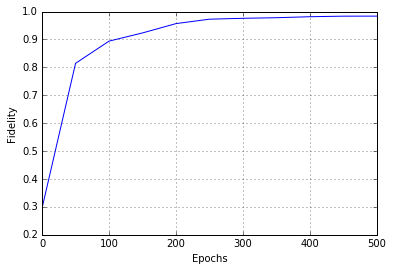

In [19]:
rbm_real = BinomialRBM(num_visible, num_hidden)
rbm_real.fit(train_set1, true_psi1, epochs, batch_size, k, lr, log_every)

### After Training 

After training your RBM, the *fit* function will have saved your trained weights and biases. Now, you have the option to generate new data from the trained RBM. The *rbm_real* object has a *sample* function that takes the following arguments.

1. The number of samples you wish to generate, *num_samples*.
2. The number of contrastive divergence steps performed to generate the samples, *k*.

In [20]:
num_samples = 100
k           = 10

rbm_real.sample(num_samples, k)

You will now find the *generated_samples_realRBM.pkl* file in your directory that contains your new samples.

### ComplexRBM

Let's now go through training a complex wavefunction. To evaluate how the RBM is training, we will again compute the fidelity between the true wavefunction of the system and the wavefunction the RBM reconstructs. Again, we first need to load our training data and the true wavefunction of this system. However, we also need the corresponding file that contains all of the measurements that each site is in. The dummy dataset we will train our RBM on is a two qubit system who's wavefunction is $\psi =\left.\frac{1}{2}\right\vert+,+\rangle - \left.\frac{1}{2}\right\vert+,-\rangle + \left.\frac{i}{2}\right\vert-,+\rangle - \left.\frac{i}{2}\right\vert-,\rangle$, where $+$ and $-$ represent spin-up and spin-down, respectively.



In [21]:
train_set2 = np.loadtxt('2qubits_train_samples.txt', dtype= 'float32')
psi_file   = np.loadtxt('2qubits_psi.txt')
true_psi2  = torch.tensor([psi_file[:,0], psi_file[:,1]], dtype = torch.double)
bases      = np.loadtxt('2qubits_train_bases.txt', dtype = str)

The following arguments are required to construct a **ComplexRBM** object.

1. **A dictionary containing 2x2 unitaries, *unitaries***. We will create this dictionary in the next block with the hand of the module we imported called *unitary_library*.
2. **The number of visible units, *num_visible***. This is 2 for the case of our dataset.
3. **The number of hidden units in the amplitude hidden layer of the RBM, *num_hidden_amp***. It's recommended that the number of hidden units stay equal to the number of visible units (2 in the case of our dummy dataset).
4. **The number of hidden units in the phase hidden layer of the RBM, *num_hidden_amp***. It's recommended that the number of hidden units stay equal to the number of visible units (2 in the case of our dummy dataset).

In [22]:
unitaries = unitary_library.create_dict()
'''If you would like to add your own quantum gates from your experiment to "unitaries", do:
unitaries = unitary_library.create_dict(name='your_name', 
                                        unitary=torch.tensor([[real part], [imaginary part]], dtype=torch.double)
For example: 
unitaries = unitary_library.create_dict(name='qucumber', unitary=torch.tensor([ [[1.,0.],[0.,1.]] 
                                                                                [[0.,0.],[0.,0.]] ], dtype=torch.double))
                                                                                             
By default, unitary_library.create_dict() contains the hadamard and K gates with keys X and Y, respectively.'''

num_visible      = train_set2.shape[-1] # 2
num_hidden_amp   = train_set2.shape[-1] # 2
num_hidden_phase = train_set2.shape[-1] # 2

Like **BinomialRBM**, a **ComplexRBM** object has a function called *fit* that performs the training. *fit* takes the following arguments.

1. ***train_set***. Needed for selecting mini batches of the data.
2. ***bases***. Needed for calculating gradients (performing the correct rotations).
2. ***true_psi***. Only needed here to compute the fidelity.
3. **The number of epochs, *epochs***. The number of training cycles that will be performed. 15 should be fine.
4. **The mini batch size, *batch_size***. The number of data points that each mini batch will contain. We'll go with 10.
5. **The number of contrastive divergence steps, *k***. One contrastive divergence step seems to be good enough in most cases.
6. **The learning rate, *lr***. We will use a learning rate of 0.01 here.
7. **How often you would like the program to update you during training, *log_every***. Every 10 epochs the program will print out the fidelity.

In [23]:
epochs     = 15
batch_size = 10
k          = 1
lr         = 0.01
log_every  = 5

Epoch =  0 
Fidelity =  tensor(1.00000e-03 *
       1.5303, dtype=torch.float64)
Epoch =  5 
Fidelity =  tensor(0.3501, dtype=torch.float64)
Epoch =  10 
Fidelity =  tensor(0.9747, dtype=torch.float64)
Epoch =  15 
Fidelity =  tensor(0.9989, dtype=torch.float64)
Finished training. Saving results...
Done.


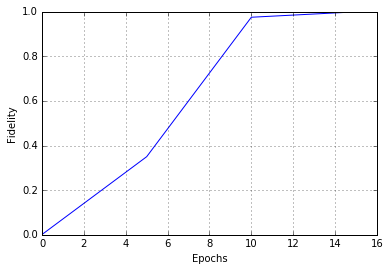

In [24]:
rbm_complex = ComplexRBM(num_visible, num_hidden_amp, num_hidden_phase)
rbm_complex.fit(train_set2, bases, true_psi2, unitaries, epochs, batch_size, k, lr, log_every)

### After Training 

After training your RBM, the *fit* function will have saved your trained weights and biases for the amplitude and the phase. Now, you have the option to generate new data from the trained RBM. The *rbm_real* object has a *sample* function that takes the following arguments.

1. The number of samples you wish to generate, *num_samples*.
2. The number of contrastive divergence steps performed to generate the samples, *k*.

In [25]:
num_samples = 100
k           = 10

rbm_complex.sample(num_samples, k)

You will now find the *generated_samples_complexRBM.pkl* file in your directory that contains your new samples.